In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import sys
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import re
from networkx.drawing.nx_agraph import graphviz_layout
from tqdm import tqdm

sns.reset_orig()
sys.path.append('../')

from src import CLEAN_100K_PATENTS_PATH, CLEAN_PATENTS_PATH, CITATIONS_PATH, TAGS_PATH, DATA_PATH
from src import TEXT_EMBEDDING_PATH
from src.data import PatentsDataset, PatentsPairsDataFrame
from src.models.similarities import *

INFO:transformers.file_utils:PyTorch version 1.4.0 available.


In [3]:
# Random sample for comparison
patents = PatentsDataset(CLEAN_PATENTS_PATH,
                         ipc_tags_format='list',
                         clean_df=False, 
                         from_year=2000,
                         path_to_citations=CITATIONS_PATH, 
                         path_to_ipc_tags_embeddings_pkl=f'{TAGS_PATH}/sf=0.5.pkl')

INFO:root:Start reading data.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/patents-clean.csv. Number of patents: 6,881,033.
INFO:root:Skip cleaning.
INFO:root:Dropped patents, older than 2000-01-01. Number of patents: 5,194,288.
INFO:root:Start reading citations.
INFO:root:Read /Users/valik/LMU/patent-similarity-siemens/data/citations-only-type-x.csv. Number of citations: 6,041,402.
INFO:root:Start creating undirected citations graph.
INFO:root:Citations graph created. Number of edges: 6,041,398. Number of nodes: 6,882,086
INFO:root:Reading ipc tags embeddings.


## Sampling algorithm for slides

In [10]:
# Time-based split
train_pairs = PatentsPairsDataFrame(patents, from_year=2000, till_year=2020, n_samples=20, n_pos_neg_per_sample=50,
                                   name='train')

INFO:root:Start creating evaluation dataframe of patent pairs.
INFO:root:Sampling columns of similarity matrix. Creating positive pairs.
INFO:root:Sampling columns of similarity matrix. Creating negative pairs.
100%|██████████| 20/20 [00:14<00:00,  1.39it/s]
INFO:root:Evaluation data-frame created.
INFO:root:Calculating mean ipc textual embeddings.


INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 1000/1000 [00:00<00:00, 16298.62it/s]


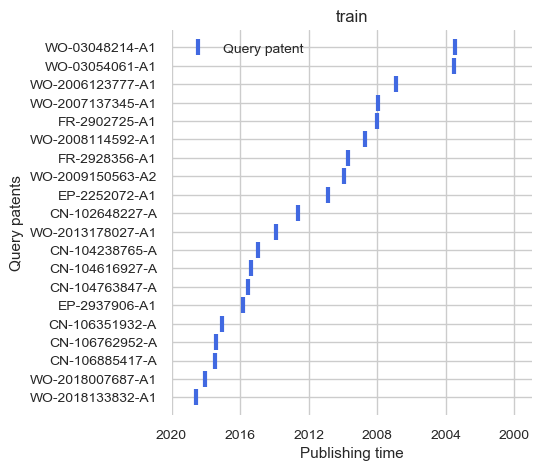

In [32]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

pub_numbers = train_pairs.query_patents_list
time_limits=(pd.to_datetime('2020-01-01'), pd.to_datetime('1999-01-01'))

from src.models.similarities import BidirXCitationSimilarity
x_cit_sim = BidirXCitationSimilarity(citations_graph=train_pairs.citations_graph, n_hops=1)
x_cit_sim.evaluate(train_pairs)

for i, pub_number in enumerate(pub_numbers):
#     x_neg = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
#                           train_pairs.pairs_df.x_citation_1_hop_sim.isna()].date_y
#     x_pos = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
#                           (train_pairs.pairs_df.x_citation_1_hop_sim == 1.0)].date_y
    x_self = train_pairs.pairs_df[train_pairs.pairs_df.pub_number_x == pub_number].date_x.iloc[0]

#     ax.plot(x_neg, np.zeros(len(x_neg)) + i / 2, '|', ms=10, color='grey', markeredgewidth=1,
#             label='Negatives' if i == 0 else None)
#     ax.plot(x_pos, np.zeros(len(x_pos)) + i / 2, '|', ms=12, color='red', markeredgewidth=2,
#             label='Positives' if i == 0 else None)
    ax.plot(x_self, i / 2, '|', ms=12, markeredgewidth=3, color='royalblue',
            label='Query patent' if i == 0 else None)

ax.set_xlim(*time_limits)
ax.set_yticks(np.arange(0, len(pub_numbers) // 2, 0.5))
ax.set_yticklabels(pub_numbers)
ax.grid()
ax.set_title(train_pairs.name)
ax.set_xlabel('Publishing time')
ax.set_ylabel('Query patents')
ax.legend()

plt.gcf().subplots_adjust(left=0.3)
plt.savefig('../reports/figures/sampling_explanation_1.png', dpi = 300)

plt.show()

INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 1000/1000 [00:00<00:00, 23239.59it/s]


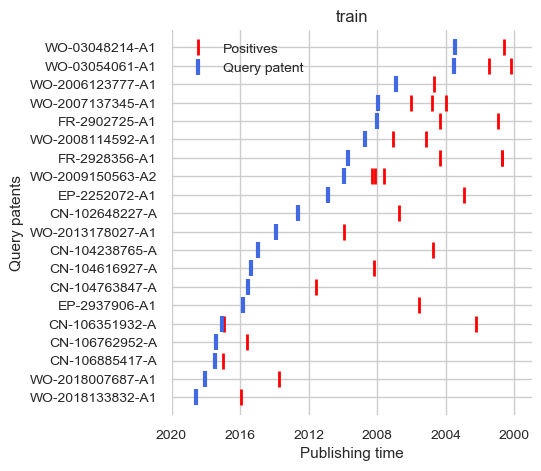

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

pub_numbers = train_pairs.query_patents_list
time_limits=(pd.to_datetime('2020-01-01'), pd.to_datetime('1999-01-01'))

from src.models.similarities import BidirXCitationSimilarity
x_cit_sim = BidirXCitationSimilarity(citations_graph=train_pairs.citations_graph, n_hops=1)
x_cit_sim.evaluate(train_pairs)

for i, pub_number in enumerate(pub_numbers):
#     x_neg = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
#                           train_pairs.pairs_df.x_citation_1_hop_sim.isna()].date_y
    x_pos = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
                          (train_pairs.pairs_df.x_citation_1_hop_sim == 1.0)].date_y
    x_self = train_pairs.pairs_df[train_pairs.pairs_df.pub_number_x == pub_number].date_x.iloc[0]

#     ax.plot(x_neg, np.zeros(len(x_neg)) + i / 2, '|', ms=10, color='grey', markeredgewidth=1,
#             label='Negatives' if i == 0 else None)
    ax.plot(x_pos, np.zeros(len(x_pos)) + i / 2, '|', ms=12, color='red', markeredgewidth=2,
            label='Positives' if i == 0 else None)
    ax.plot(x_self, i / 2, '|', ms=12, markeredgewidth=3, color='royalblue',
            label='Query patent' if i == 0 else None)

ax.set_xlim(*time_limits)
ax.set_yticks(np.arange(0, len(pub_numbers) // 2, 0.5))
ax.set_yticklabels(pub_numbers)
ax.grid()
ax.set_title(train_pairs.name)
ax.set_xlabel('Publishing time')
ax.set_ylabel('Query patents')
ax.legend()

plt.gcf().subplots_adjust(left=0.3)
plt.savefig('../reports/figures/sampling_explanation_2.png', dpi = 300)

plt.show()

INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 1000/1000 [00:00<00:00, 19508.03it/s]


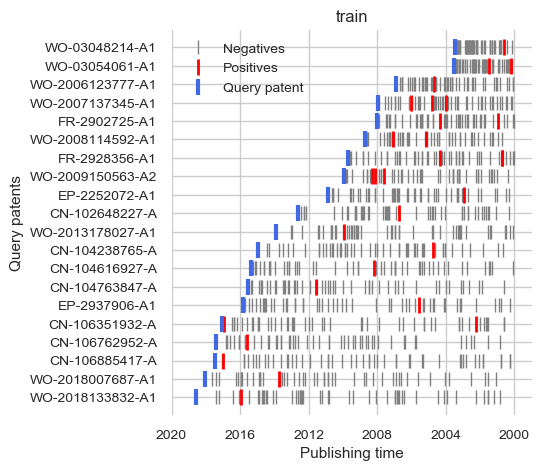

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(6, 5))

pub_numbers = train_pairs.query_patents_list
time_limits=(pd.to_datetime('2020-01-01'), pd.to_datetime('1999-01-01'))

from src.models.similarities import BidirXCitationSimilarity
x_cit_sim = BidirXCitationSimilarity(citations_graph=train_pairs.citations_graph, n_hops=1)
x_cit_sim.evaluate(train_pairs)

for i, pub_number in enumerate(pub_numbers):
    x_neg = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
                          train_pairs.pairs_df.x_citation_1_hop_sim.isna()].date_y
    x_pos = train_pairs.pairs_df[(train_pairs.pairs_df.pub_number_x == pub_number) &
                          (train_pairs.pairs_df.x_citation_1_hop_sim == 1.0)].date_y
    x_self = train_pairs.pairs_df[train_pairs.pairs_df.pub_number_x == pub_number].date_x.iloc[0]

    ax.plot(x_neg, np.zeros(len(x_neg)) + i / 2, '|', ms=10, color='grey', markeredgewidth=1,
            label='Negatives' if i == 0 else None)
    ax.plot(x_pos, np.zeros(len(x_pos)) + i / 2, '|', ms=12, color='red', markeredgewidth=2,
            label='Positives' if i == 0 else None)
    ax.plot(x_self, i / 2, '|', ms=12, markeredgewidth=3, color='royalblue',
            label='Query patent' if i == 0 else None)

ax.set_xlim(*time_limits)
ax.set_yticks(np.arange(0, len(pub_numbers) // 2, 0.5))
ax.set_yticklabels(pub_numbers)
ax.grid()
ax.set_title(train_pairs.name)
ax.set_xlabel('Publishing time')
ax.set_ylabel('Query patents')
ax.legend()

plt.gcf().subplots_adjust(left=0.3)
plt.savefig('../reports/figures/sampling_explanation_3.png', dpi = 300)

plt.show()

## Train-test splits

In [69]:
# Time-based split
train_pairs = PatentsPairsDataFrame(patents, from_year=2000, till_year=2010, n_samples=8, n_pos_neg_per_sample=50,
                                   name='train')
test_pairs = PatentsPairsDataFrame(patents, from_year=2010, till_year=2020, n_samples=8, n_pos_neg_per_sample=50,
                                    name='test')

INFO:root:Start creating evaluation dataframe of patent pairs.
INFO:root:Sampling columns of similarity matrix. Creating positive pairs.
INFO:root:Sampling columns of similarity matrix. Creating negative pairs.
100%|██████████| 8/8 [00:02<00:00,  2.70it/s]
INFO:root:Evaluation data-frame created.
INFO:root:Calculating mean ipc textual embeddings.
INFO:root:Start creating evaluation dataframe of patent pairs.
INFO:root:Sampling columns of similarity matrix. Creating positive pairs.
INFO:root:Sampling columns of similarity matrix. Creating negative pairs.
100%|██████████| 8/8 [00:07<00:00,  1.03it/s]
INFO:root:Evaluation data-frame created.
INFO:root:Calculating mean ipc textual embeddings.


INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 400/400 [00:00<00:00, 22175.37it/s]
INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 400/400 [00:00<00:00, 21558.45it/s]


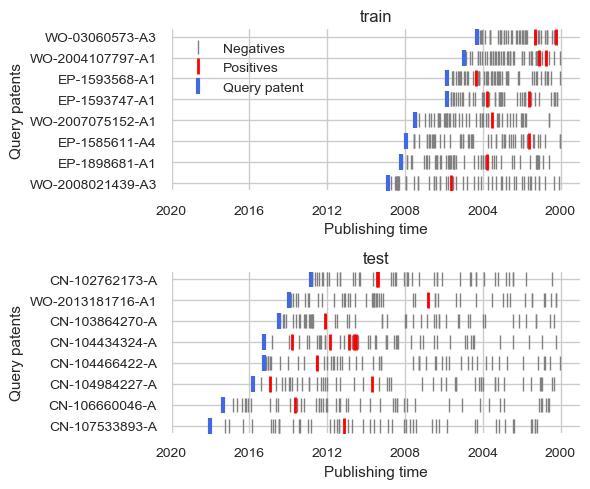

In [73]:
# Visualisations of splits
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
train_pairs.visualise_pairs_df(ax[0])
test_pairs.visualise_pairs_df(ax[1])
ax[1].get_legend().remove()
plt.tight_layout()
# fig.suptitle("Time-based split")
plt.savefig('../reports/figures/sampling_time_based.png', dpi = 300)
plt.show()

In [74]:
# Manual exclusion split
train_pairs = PatentsPairsDataFrame(patents, name='train', n_pos_neg_per_sample=50, n_samples=8)

queries_to_exclude = list(train_pairs.pairs_df.pub_number_x.unique()) +\
                     list(train_pairs.pairs_df.pub_number_y.unique())
test_pairs = PatentsPairsDataFrame(patents, name='test', queries_to_exclude=queries_to_exclude,
                                   n_pos_neg_per_sample=50, n_samples=8)

INFO:root:Start creating evaluation dataframe of patent pairs.
INFO:root:Sampling columns of similarity matrix. Creating positive pairs.
INFO:root:Sampling columns of similarity matrix. Creating negative pairs.
100%|██████████| 8/8 [00:06<00:00,  1.29it/s]
INFO:root:Evaluation data-frame created.
INFO:root:Calculating mean ipc textual embeddings.
INFO:root:Start creating evaluation dataframe of patent pairs.
INFO:root:Sampling columns of similarity matrix. Creating positive pairs.
INFO:root:Sampling columns of similarity matrix. Creating negative pairs.
100%|██████████| 8/8 [00:06<00:00,  1.30it/s]
INFO:root:Evaluation data-frame created.
INFO:root:Calculating mean ipc textual embeddings.


INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 400/400 [00:00<00:00, 21707.40it/s]
INFO:root:Calculating x_citation_1_hop_sim.
100%|██████████| 400/400 [00:00<00:00, 23394.62it/s]


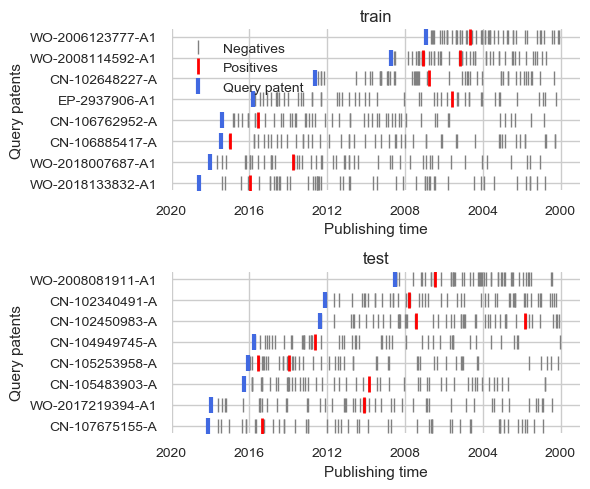

In [76]:
# Visualisations of splits
fig, ax = plt.subplots(2, 1, figsize=(6, 5))
train_pairs.visualise_pairs_df(ax[0])
test_pairs.visualise_pairs_df(ax[1])
ax[1].get_legend().remove()
plt.tight_layout()
# fig.suptitle("Manual exclusion split (with non-overlapping queries)"
plt.savefig('../reports/figures/sampling_manual_exclusion.png', dpi = 300)
plt.show()